In [6]:
from pandas import to_datetime
import os
import warnings
warnings.filterwarnings('ignore')
from astropy.table import Table
from astropy import units as u
from astropy.time import Time
from datetime import date
import astropy.io.fits as fits
import warnings
warnings.filterwarnings('ignore')
from astropy.nddata import StdDevUncertainty
from compileheader import *
import numpy as np
from unicodedata import normalize
# change to Suárez

In [2]:
#TO DO:
#figure out header keyword for observatory

https://ui.adsabs.harvard.edu/abs/2022MNRAS.513.5701S/abstract

In [3]:
table_file='IRS Spectrum - Daniel  - Sheet1.csv'
data = Table.read(table_file)
original_data_dir = 'IRS_Spectra_of_113_Field_M5-T9_Dwarfs_in_Suarez-Metchev2022/' #where the old fits files are
fits_data_dir = 'Suarez2022/' #where we want the new fits files to go 
wavelength_unit = u.micron  #using astropy to defien units 
flux_unit = u.Jy

#dictionary values:
bandpass = None
aperture = None
vopub = 'SIMPLE Archive'
voclass = None #set , corresponds to IVOA data model
title = 'IRS Spectra of Brown Dwarfs from Suarez & Metchev 2022'
bibcode = '2022MNRAS.513.5701S' 
author = 'Suarez, Genaro; Metchev, Stanimir'
doi = ' 10.1093/mnras/stac1205' 
generated_history = 'This file generated by SIMPLE-db/scripts/ingests/rewrite_spectra.py'
spectra_comments = None
flux_column = 'flux(Jy)'
flux_unc_column = 'eflux(Jy)'
wavelength_column = 'wl(um)'
object_name_column = 'Source'
spectrum_url_column = 'Spectrum'
RA_column_name = 'RA'
dec_column_name = 'dec'
start_time_column_name = 'start time'
stop_time_column_name = 'stop time'
exposure_time_column_name = 'exposure time'
instrument_column_name = 'instrument'
observation_date_column_name = 'observation_date'
telescope_column_name = 'telescope'
startline = None

#set row names out of loop

In [4]:
for row in data:
    object_name = ascii(normalize('NFD',row[object_name_column])) #set as string and ascii name here- not in hdu1.header.set
#TRY TO NORMALIzE AROUND ROW SOURCE
#use print statements to understand
#get rid of ascii()
    spectrum_url = row[spectrum_url_column]
    file = os.path.basename(spectrum_url) 
    file_root = os.path.splitext(file)[1]
    #print(file_root)

In [5]:
for row in data:
    object_name = ascii(normalize('NFD',row[object_name_column])) #set as string and ascii name here- not in hdu1.header.set
#TRY TO NORMALIzE AROUND ROW SOURCE
#use print statements to understand
#get rid of ascii()
    spectrum_url = row[spectrum_url_column]
    file = os.path.basename(spectrum_url) 
    full_name = (original_data_dir + file)

    
    history1 = f'Original file: {file}' #gives orginal name of file
    history2 = generated_history  #shows where file came from
    history = (history1 +', ' + history2)
    
    comment1 = spectra_comments
    comment = (comment1)
    
    # returns basename of pathname to be used in next line to read each spectrum which is a .csv file
    spectrum_table = Table.read(spectrum_url, format='ascii') #think about how to remove from loop, make array of arrays?
    wavelength, flux = np.empty(0), np.empty(0)
    

    flux_unc_class = StdDevUncertainty(spectrum_table[flux_column]) 
  #gives arrays of flux w units 
    
    wavelength_data = spectrum_table[wavelength_column] * wavelength_unit   #multiplying everythign by untis to convert

    spectrum_data_out = Table({'wavelength': spectrum_table[wavelength_column] * wavelength_unit , 'flux':spectrum_table[flux_column] * flux_unit , 'flux_uncertainty':spectrum_table[flux_unc_column] * flux_unit})

    hdu1 = fits.BinTableHDU(data = spectrum_data_out)

    hdu1.header['EXTNAME'] = 'SPECTRUM' #prints out different headers
   # hdu1.header.set('Spectrum', str(ascii(object_name)), 'Object Name')
    hdu1.header.set('Spectrum', object_name, 'Object Name') #take out string and ascii 
    
    try:
        ra = row[RA_column_name]
    except KeyError:
        ra = None
    try:
        dec = row[dec_column_name]
    except KeyError:
        dec = None    
    try:
        start_time = row[start_time_column_name]
    except KeyError:
        start_time = None
    try:
        time = (Time(to_datetime(row[start_time_column_name])).jd + Time(to_datetime(row[stop_time_column_name])).jd) /2  
    except KeyError:
        time = None
    try: 
        exposure_time = row[exposure_time_column_name]
    except KeyError:
        exposure_time = None  
    try:
        time_start = Time(to_datetime(row[start_time_column_name])).jd 
    except KeyError:
        time_start = None
    try:
        time_stop = Time(to_datetime(row[stop_time_column_name])).jd
    except KeyError:
        time_stop = None     
    try:
        instrument = row[instrument_column_name]
    except KeyError:
        instrument = None
    try:
        obs_date = to_datetime(row[observation_date_column_name])
    except KeyError:
        obs_date = None
    try:
        telescope = row[telescope_column_name]
    except KeyError:
        telescope = None
        
    #turn these into a dictionary
    header_dict = {
        'VOCLASS' : voclass,
        'VOPUB' : vopub ,
        'title' : title ,
        'RA' : ra ,
        'dec' : dec , #from the vizier catalog, put in csv table
        'time' : time,
        'exposure_time' : exposure_time ,
        'bandpass' : bandpass ,#get from paper
        'aperture' : aperture ,
        'object_name' : object_name,
        #'object_name' : ascii(object_name),

        #OTHER KEYWORDS
        'time_start' : time_start , #turns dates into accepetable format then converts to Time object then to MJD
        'time_stop' : time_stop, #dates r orginally in month day, year
        'bibcode' : bibcode,
        'instrument' : instrument ,
        'obs_date' : obs_date ,
        'author' : author,
        'reference_doi' : doi , 
        'telescope' : telescope ,
        'history' : history ,
        'wavelength' : wavelength_data , #multiplying everythign by untis to convert
        'wavelength_units' : f"[{wavelength_data.unit:FITS}]",
        'width' : (max(wavelength_data).value - min(wavelength_data.value)),
        'min_wave' : min(wavelength_data).value,
        'max_wave' : max(wavelength_data).value,
        'flux' : tuple(spectrum_table[flux_column].data) * flux_unit,
        'flux_unc' : tuple(spectrum_table[flux_unc_column].data) * flux_unit,
        'comment': comment
        }

    hdu0 = fits.PrimaryHDU(header=compile_header(**header_dict)) 

    spectrum_mef = fits.HDUList([hdu0,hdu1])#hdu0 is header and hdu1 is data

    file_root = os.path.splitext(file)[0] #split the path name into a pair root and ext so the root is just the ext [0] is the name of the file wihtout the .csv
    fits_filename = fits_data_dir + file_root + '.fits' #turns into fits files by putting it in new folder that we defined at begining and adding name of file then .fits
    try:
        spectrum_mef.writeto(fits_filename, overwrite=True)
        # SHOULD BE: spectrum.write(fits_filename, format='tabular-fits', overwrite=True, update_header=True)
        #logger.info(f'Wrote {fits_filename}')
    except:
        raise ValueError
        
    

In [15]:
from specutils import Spectrum1D

spec1d_fits_rt = fits.open(fits_filename)
header_rt = spec1d_fits_rt[0].header
spec1d_rt = Spectrum1D.read(fits_filename)

print(spec1d_rt)

Spectrum1D (length=187)
flux:             [ 0.007454 Jy, ..., 0.001802 Jy ],  mean=0.003912 Jy
spectral axis:    [ 5.2172 um, ..., 14.169 um ],  mean=9.0171 um
uncertainty:      [ StdDevUncertainty(0.000291), ..., StdDevUncertainty(0.000502) ]


/var/folders/zq/nmj607b96c59myhbs6bdxn2r0000gn/T/ipykernel_55661/3286613645.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  ax = plt.subplots()[1]


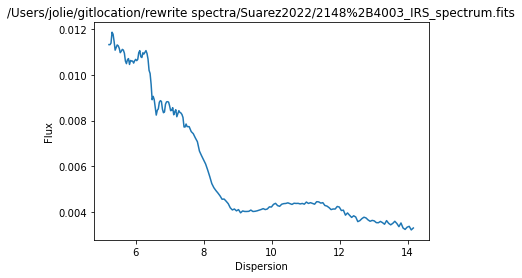

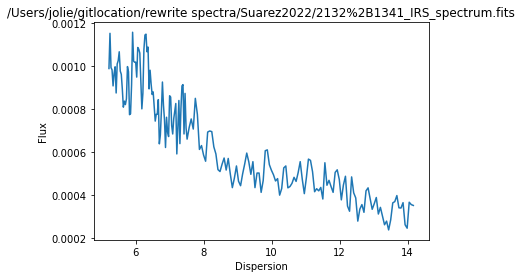

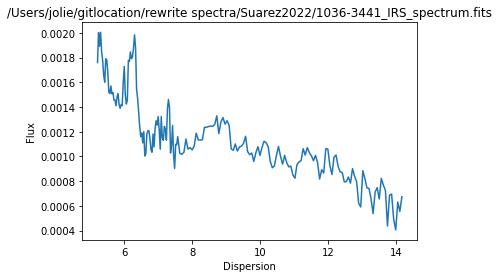

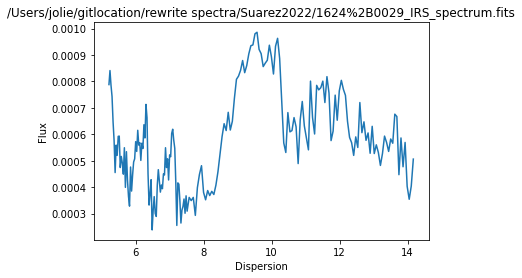

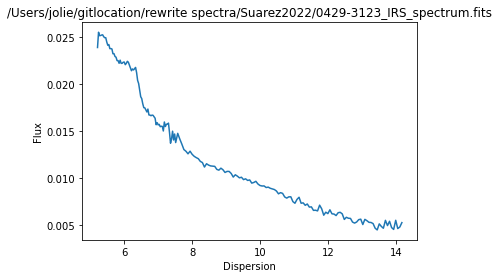

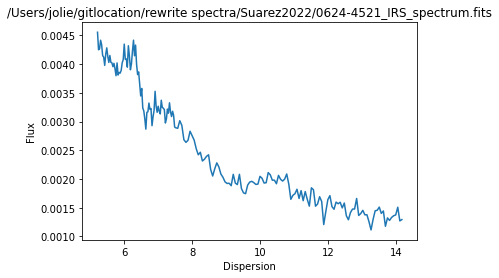

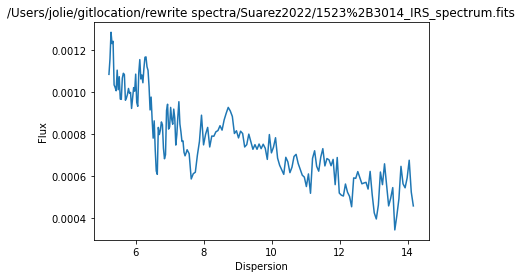

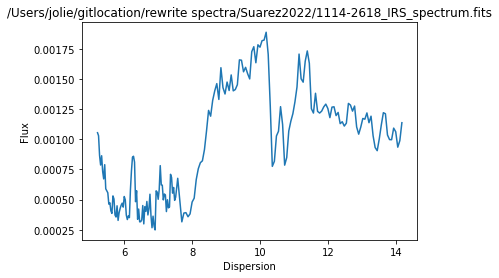

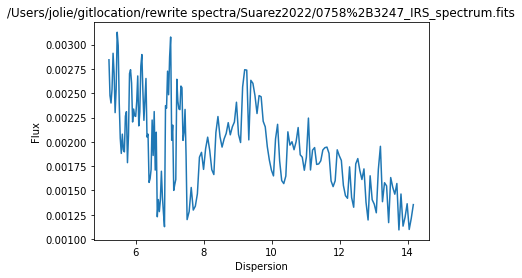

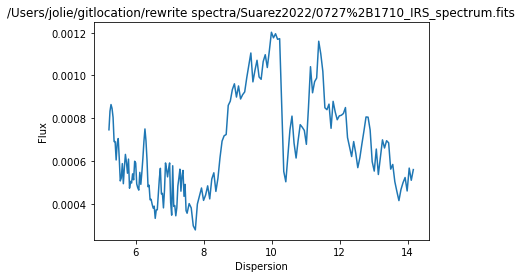

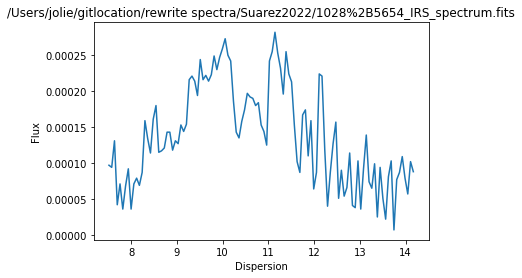

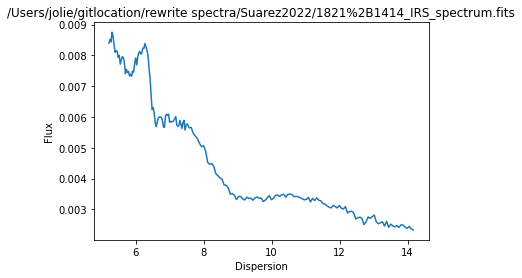

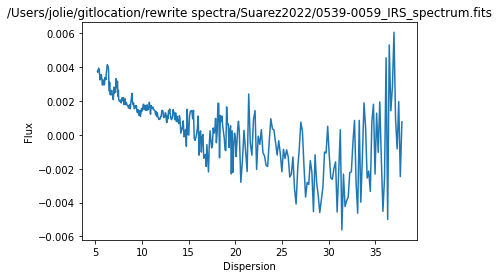

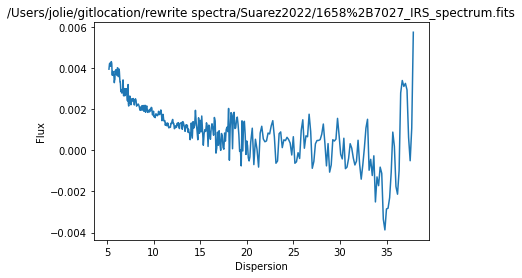

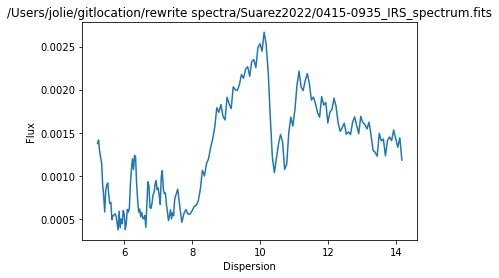

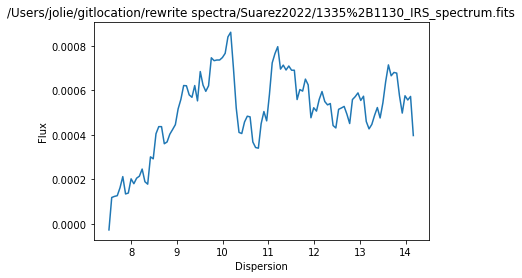

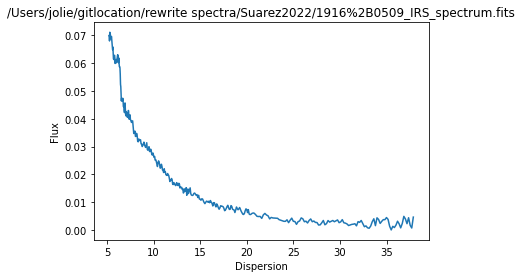

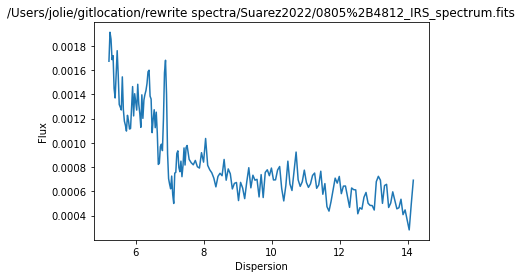

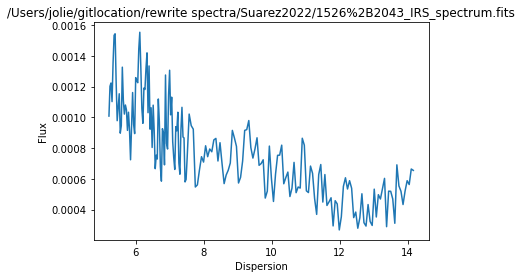

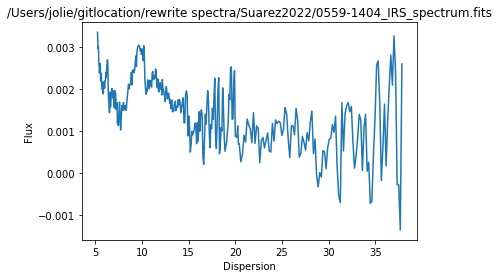

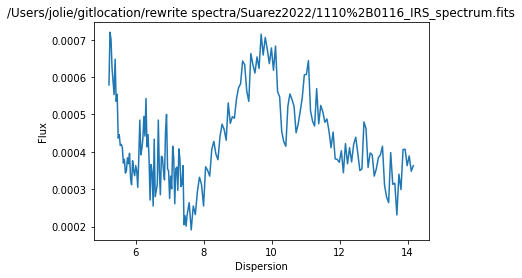

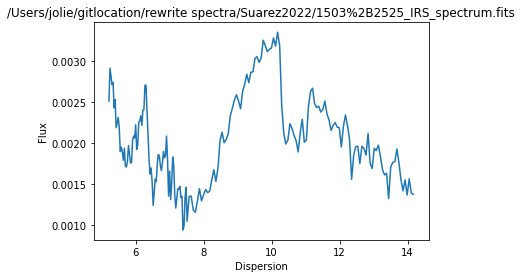

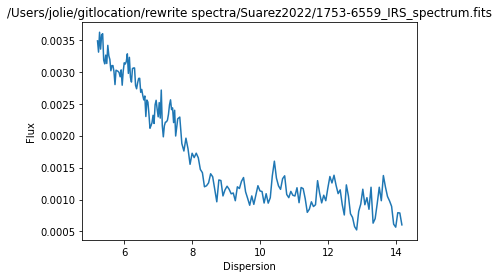

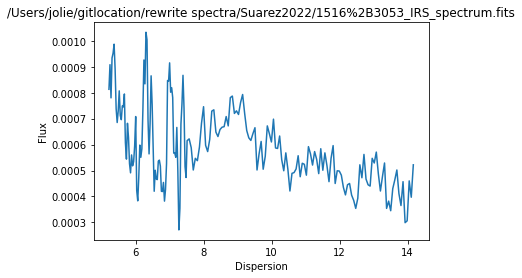

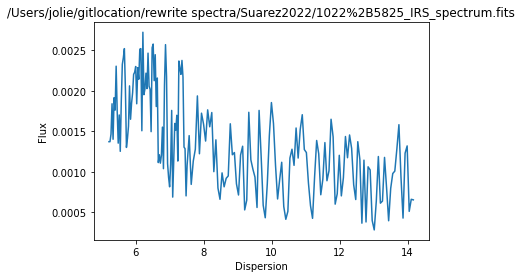

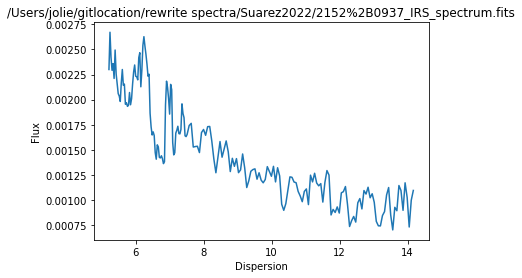

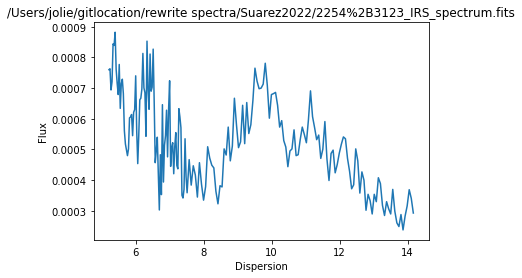

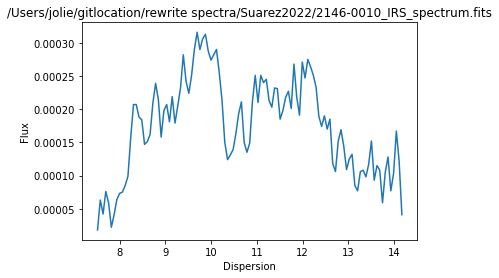

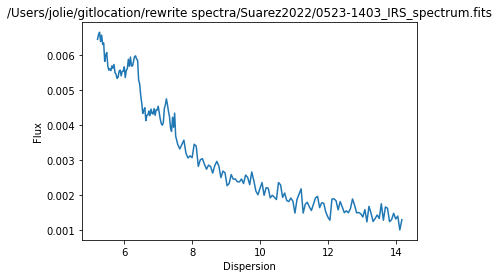

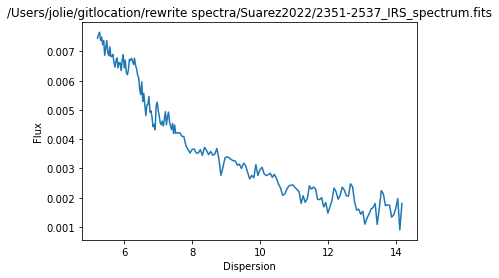

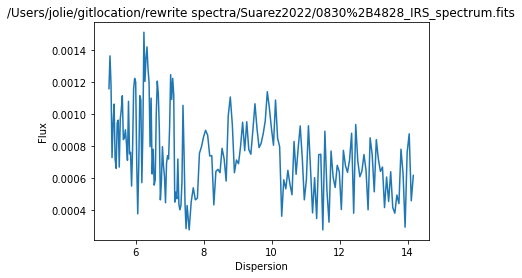

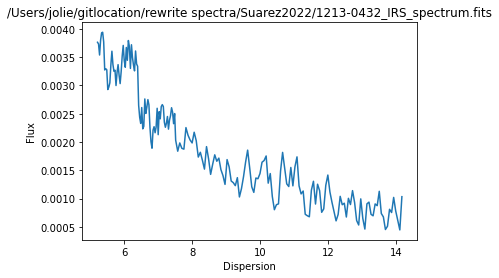

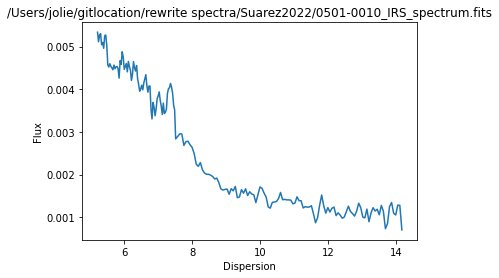

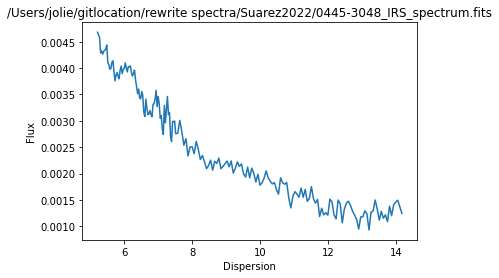

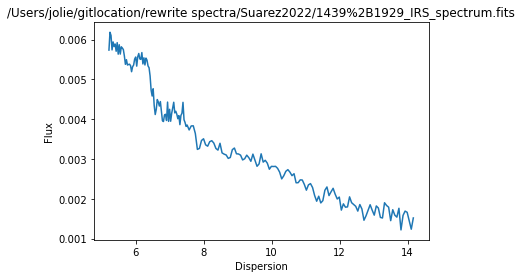

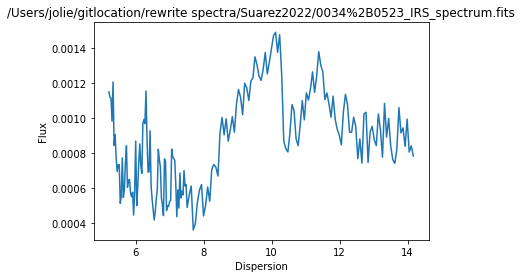

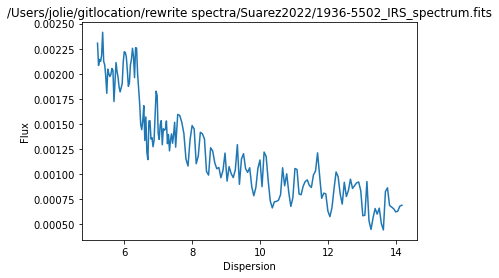

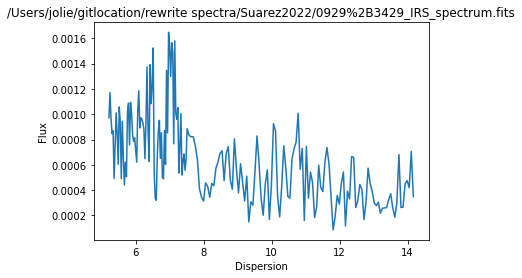

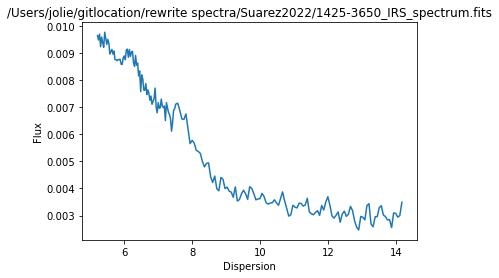

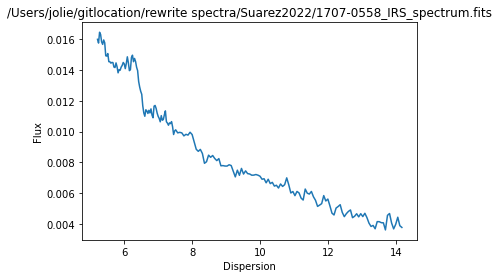

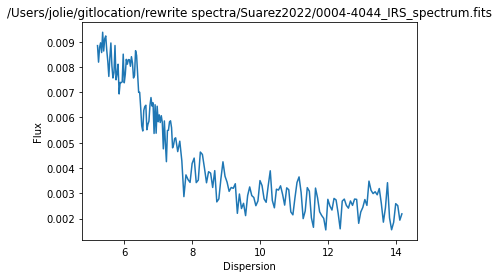

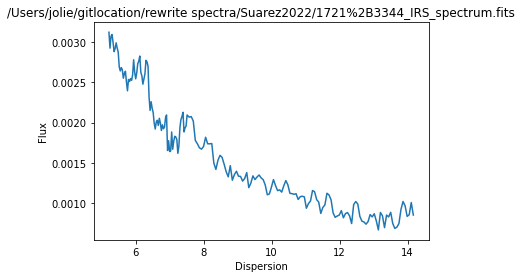

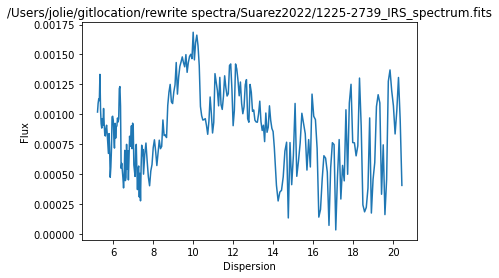

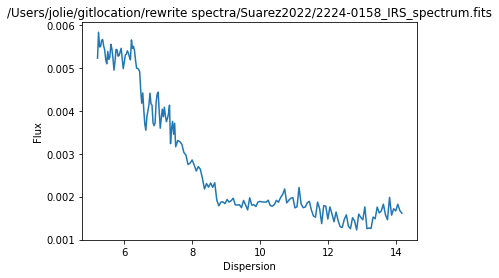

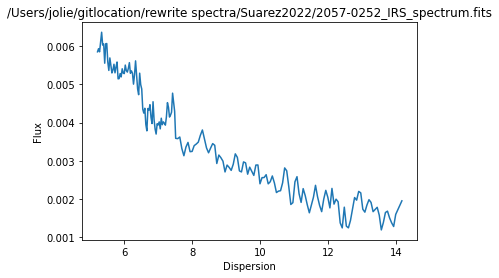

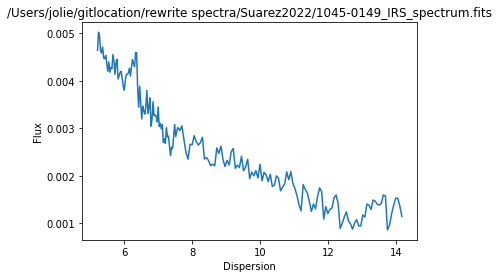

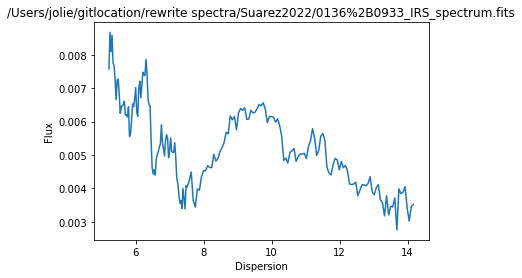

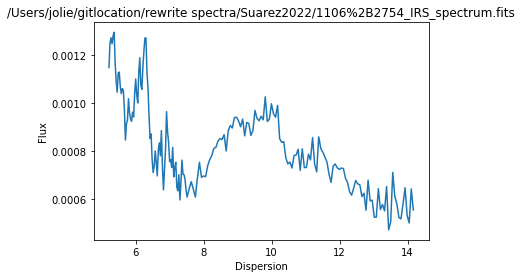

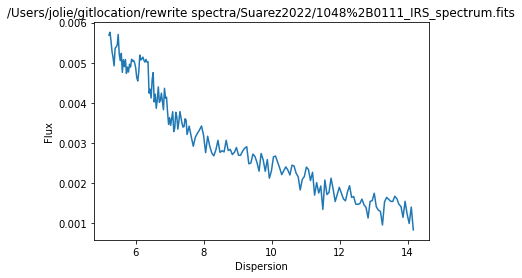

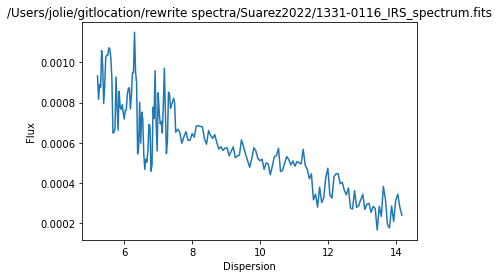

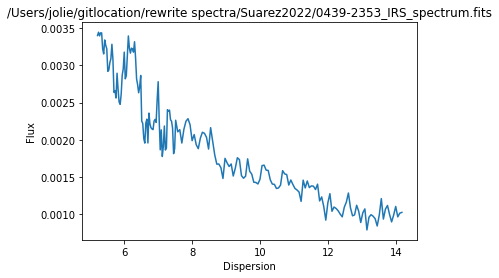

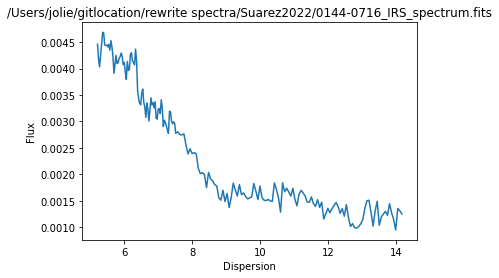

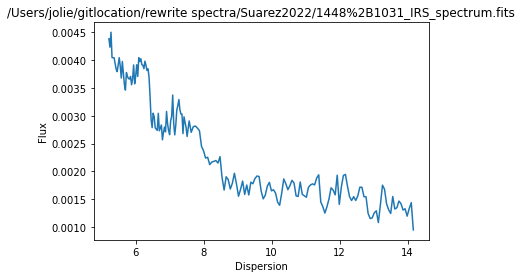

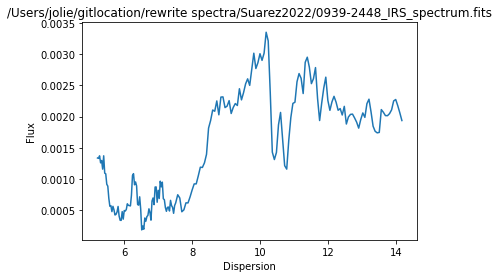

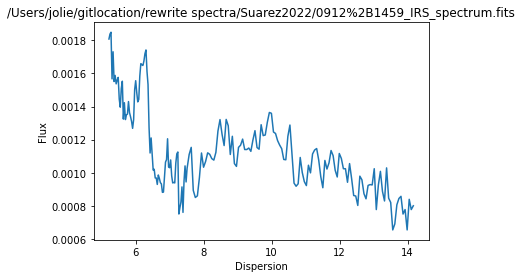

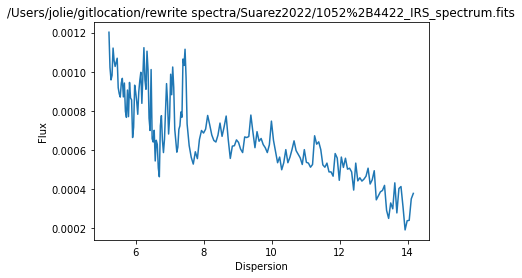

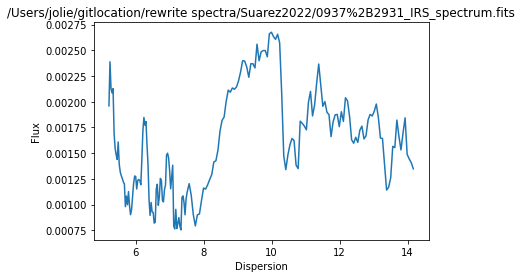

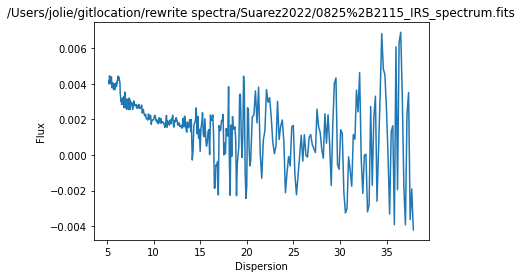

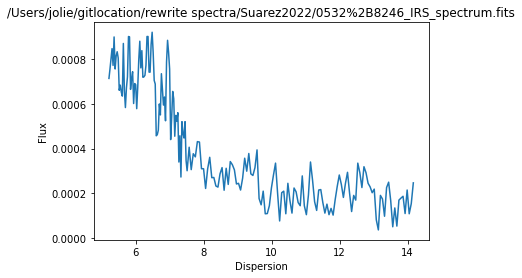

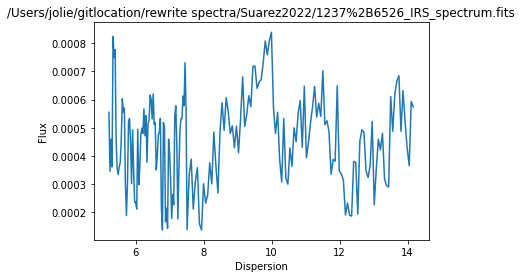

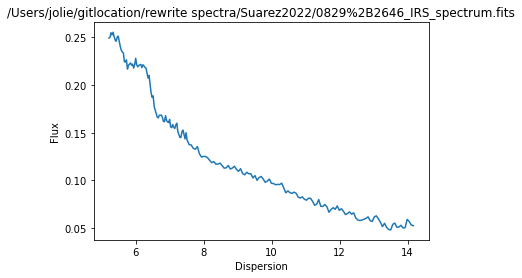

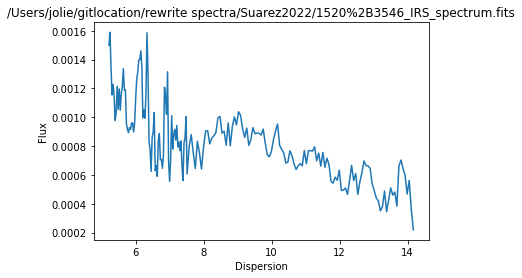

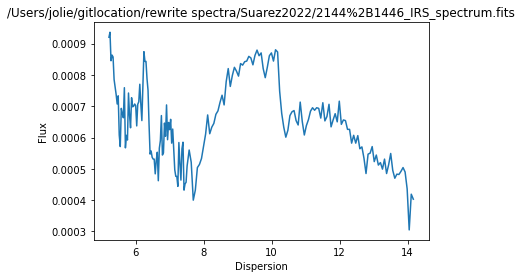

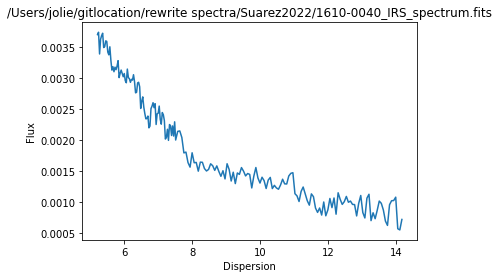

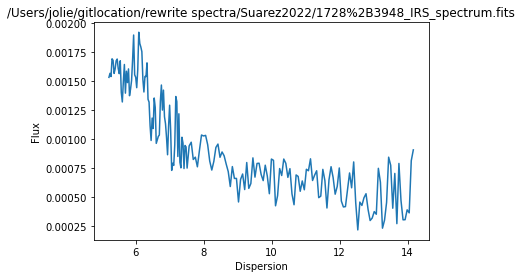

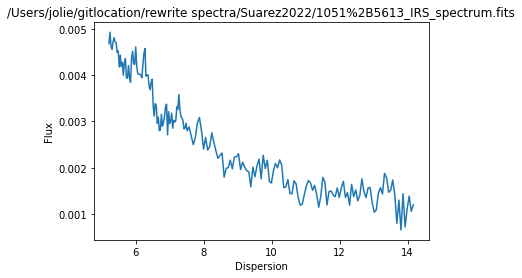

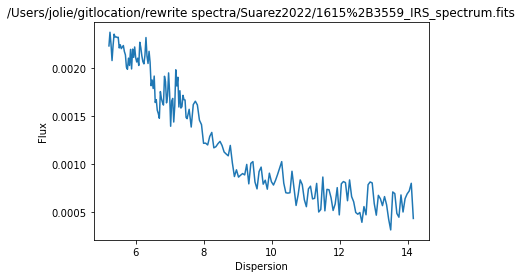

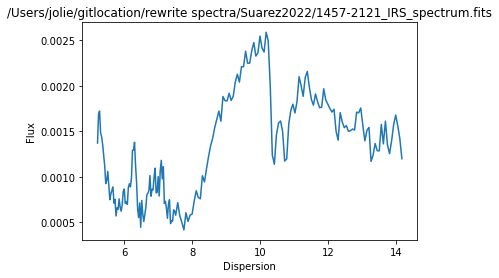

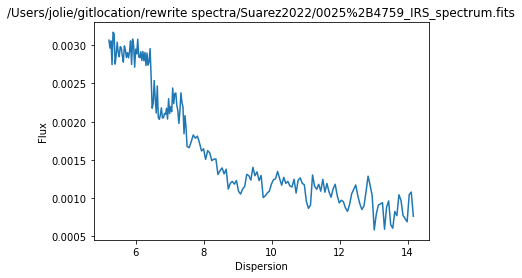

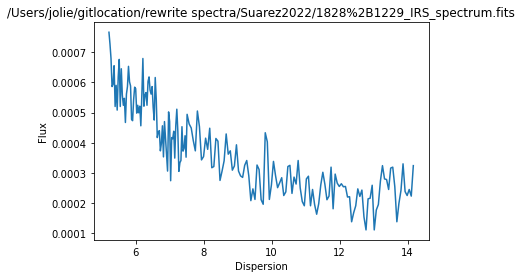

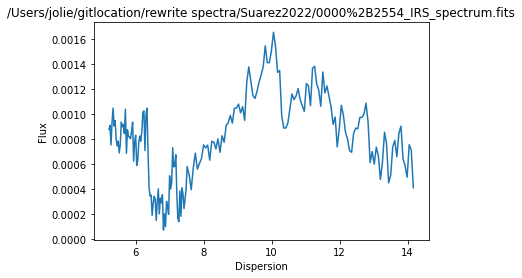

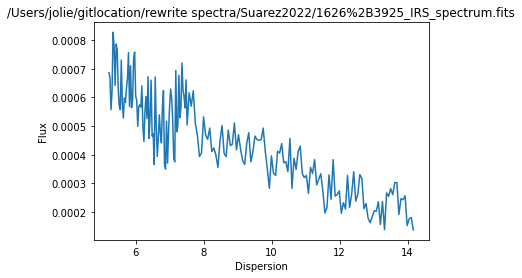

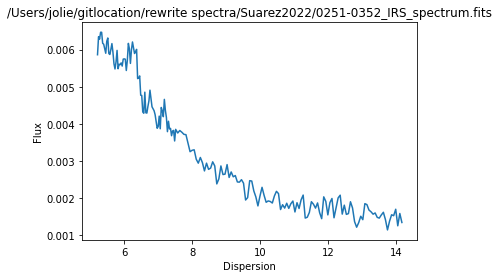

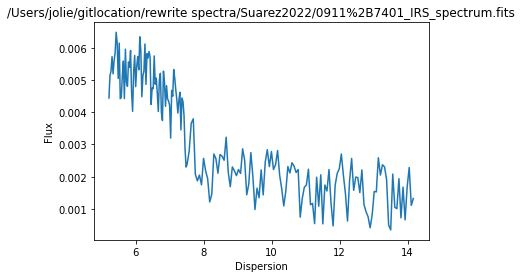

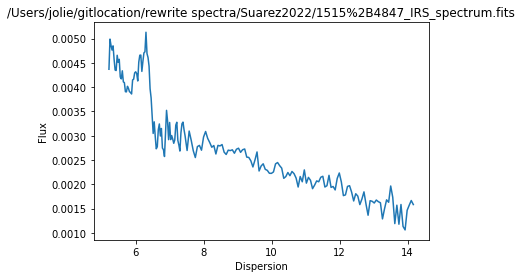

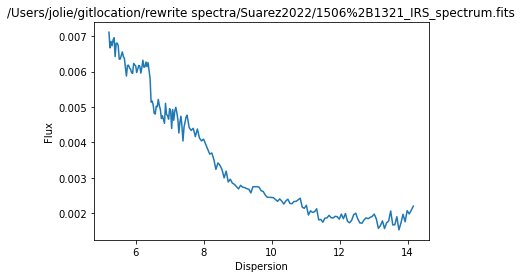

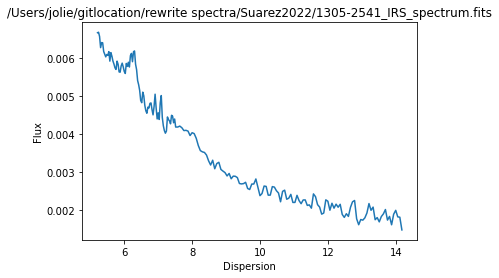

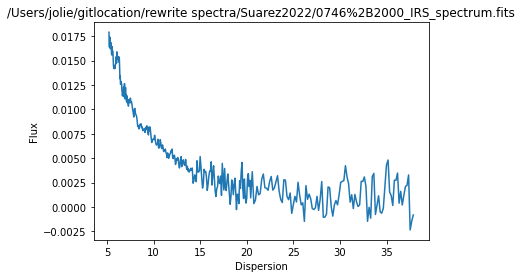

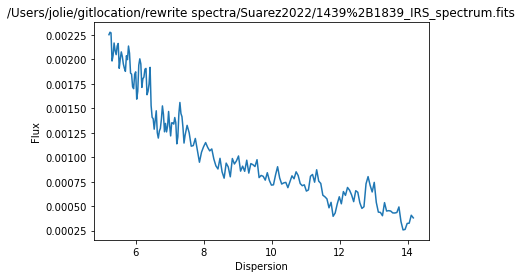

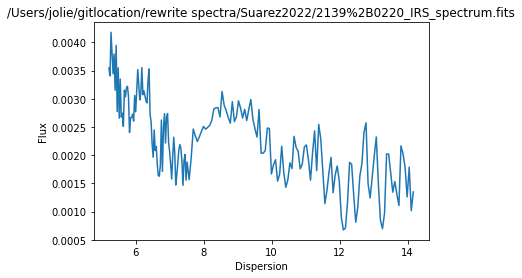

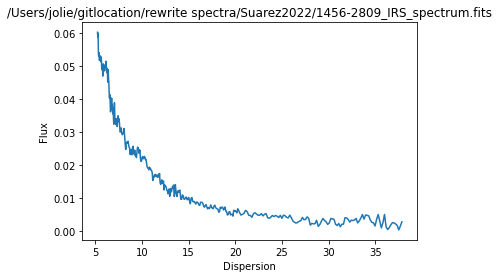

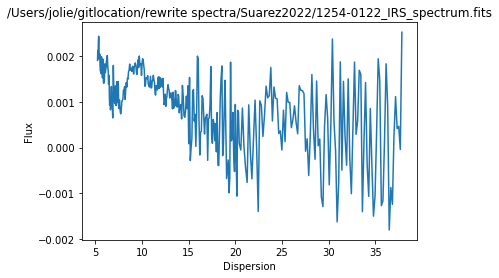

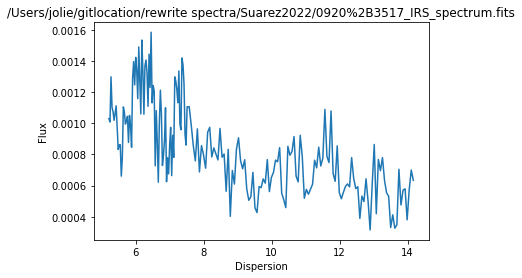

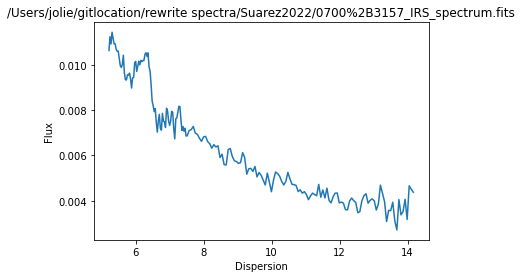

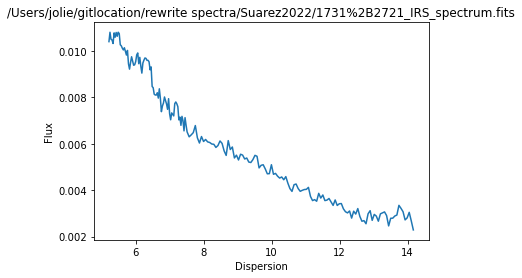

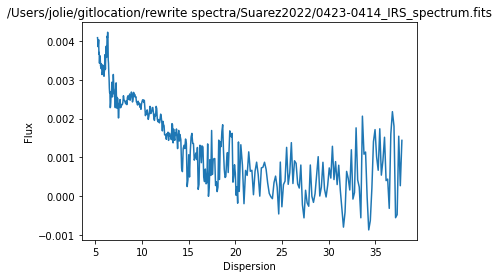

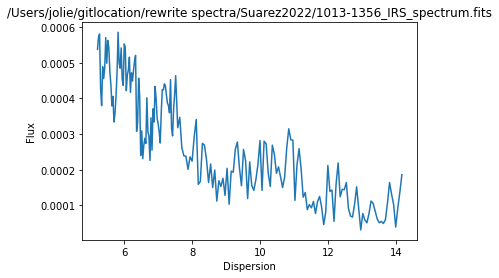

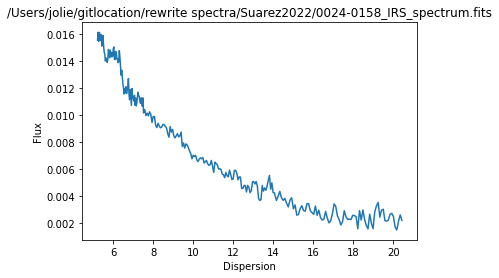

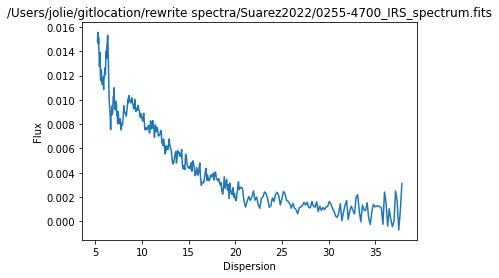

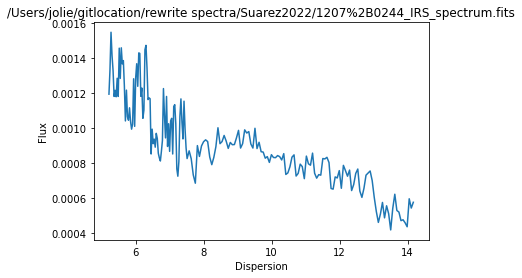

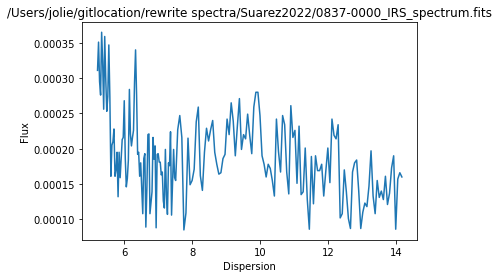

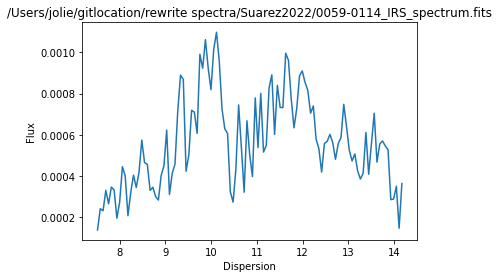

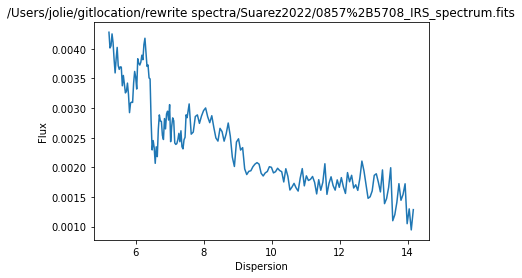

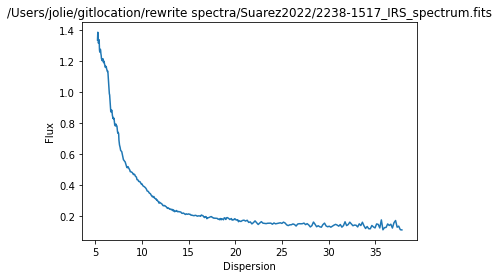

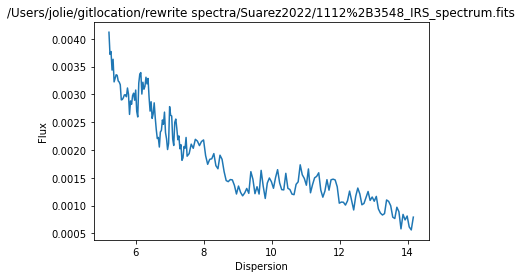

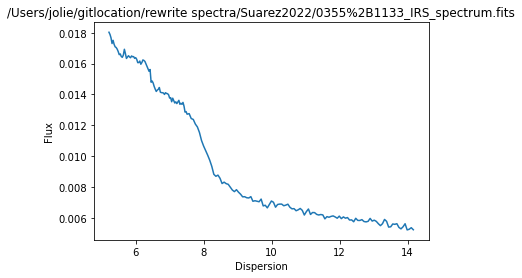

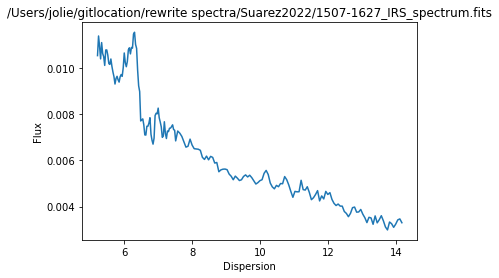

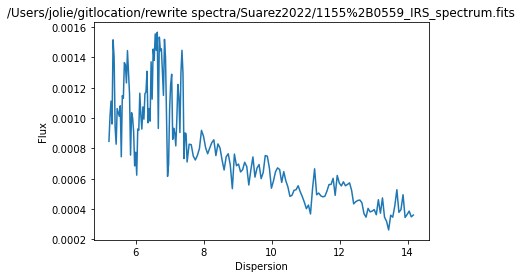

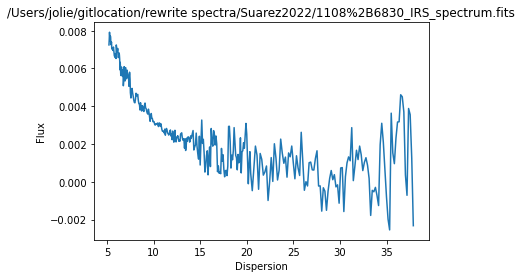

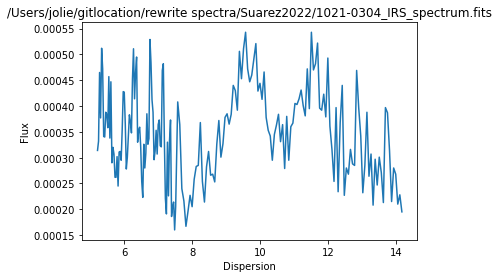

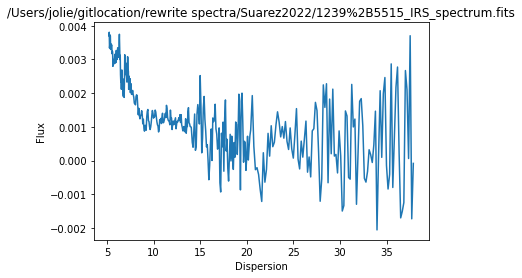

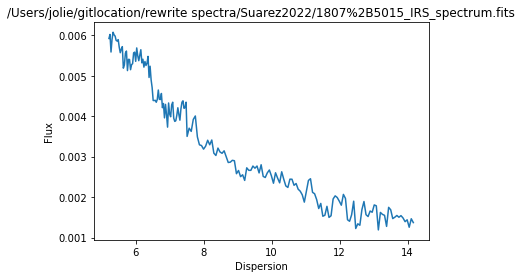

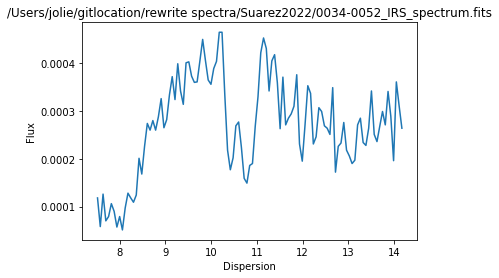

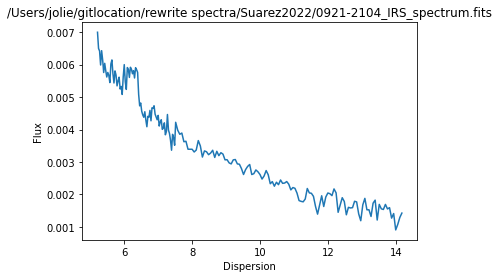

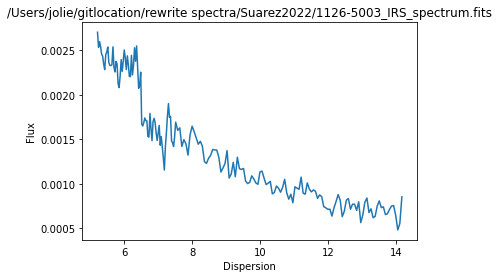

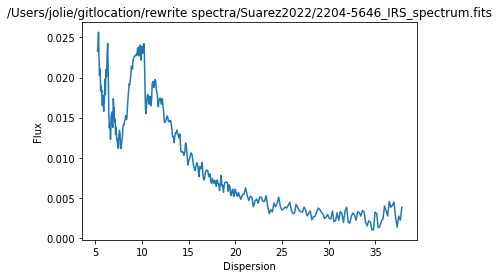

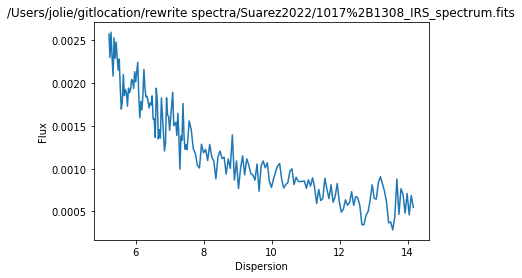

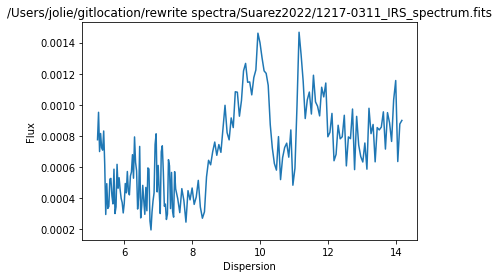

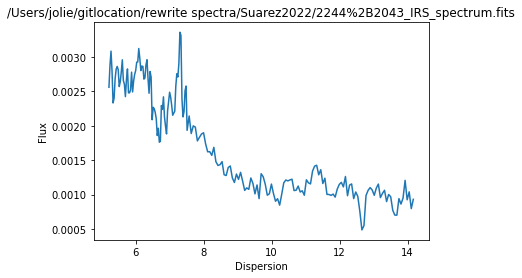

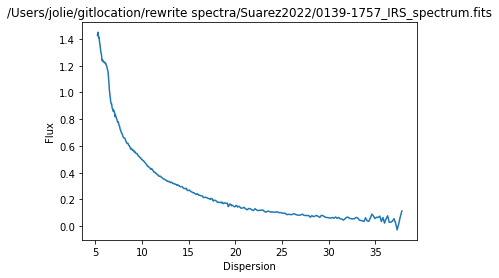

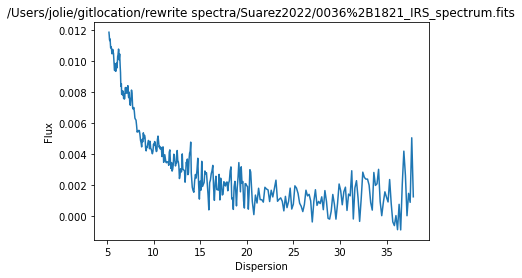

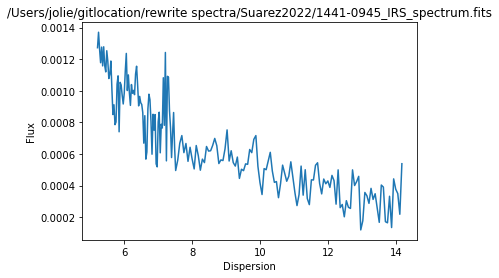

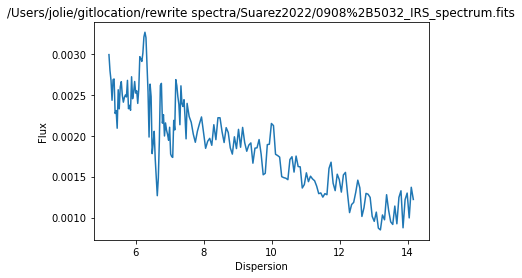

In [8]:
from glob import glob
from astropy.io import fits
from matplotlib import pyplot as plt
from specutils import Spectrum1D
from astropy import units as u

files = glob('/Users/jolie/gitlocation/rewrite spectra/Suarez2022/*.fits')
for file_name in files:
    spec1d = Spectrum1D.read(file_name, format = 'tabular-fits' )
    ax = plt.subplots()[1]  
    ax.plot(spec1d.spectral_axis, spec1d.flux)  
    ax.set_xlabel("Dispersion")  
    ax.set_ylabel("Flux")  
    plt.title(file_name)

In [119]:
files = glob('/Users/jolie/gitlocation/rewrite spectra/Suarez2022/*.fits')

for file_name in files:
    f = fits.open(file_name)
    name = file_name[48:-len('.fits')]
    specdata = f[1].data
    wavelength_unit = u.micron  #using astropy to defien units
    flux_unit = u.erg/u.cm/u.cm/u.s/u.Angstrom
    wavelength = specdata['wavelength'] * wavelength_unit # u.AA
    flux = specdata['flux'] * flux_unit #10**-17 * u.Unit('erg cm-2 s-1 AA-1')
    spec = Spectrum1D(spectral_axis=wavelength, flux=flux)
    #f, ax = plt.subplots()
    #ax.step(spec.spectral_axis, spec.flux)
    #plt.xlabel('wavelength')
    #plt.ylabel('flux ')
    #plt.title(name)
    #un-comment to plot

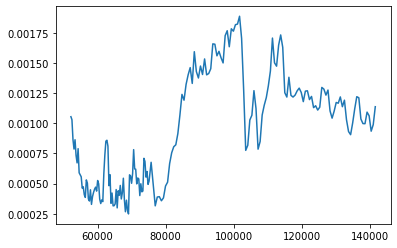

In [13]:
from specutils import Spectrum1D
import matplotlib.pyplot as plt
spec = Spectrum1D.read('Suarez2022/1114-2618_IRS_spectrum.fits', format = 'tabular-fits' )


plt.plot(spec.wavelength, spec.flux)
plt.title('2MASS J11145133-2618235')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (erg/cm2/s/A)')
plt.show()

In [7]:
from astropy.io import fits
from astropy.table import Table
hdul = fits.open('Suarez2022/1753-6559_IRS_spectrum.fits')
Table(hdul[1].data)

wavelength,flux,flux_uncertainty
float64,float64,float64
5.21725,0.003483,0.000188
5.24749,0.003307,0.000203
5.27773,0.003618,0.000266
5.30797,0.003354,0.000227
5.33821,0.003578,0.000228
5.36846,0.003595,0.000226
...,...,...
13.80593,0.000978,0.000347
13.86642,0.000893,0.00031
